# 🌪️ Lorenz 80 

## 📝 General description

This code implements the numerical simulations of the article _Attractor Sets and Quasi-Geostrophic Equilibrium_ by E.D. Lorenz (1980), which explores the dynamics of atmospheric systems using two models: the Primitive Equations (PE) and its Quasi-Geostrophic approximation (QG). 

The work seeks to reproduce the original results of the article, simulate attractors formed by the dynamic systems and make a comparison between the PE and QG models. The simulations use the fourth-order Runge-Kutta numerical method to solve the systems of differential equations.

## 📦 Libraries used

The code uses the `NumPy` libraries for mathematical operations and manipulating arrays, and `Matplotlib` for visualizing and plotting graphs.

## 🔢 Vectors and constants

All vectors and constants were defined following section 04, _Choice of numerical values_ of the article [1], except for the first element of the force vector $F$, i.e., $F_1$. For the simulations, $F_1 = 0.1$. This value is defined in section 05, _Behavior of the model_ of the same article [1].

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

vector_a = [1, 1, 3]
vector_b = [
    0.5 * (vector_a[0] - vector_a[1] - vector_a[2]),
    0.5 * (vector_a[1] - vector_a[2] - vector_a[0]),
    0.5 * (vector_a[2] - vector_a[0] - vector_a[1]),
]
c = np.sqrt(3 / 4)

f_inv = 10800
vector_h = [-1, 0, 0]
vector_f = [0.1, 0, 0]
g_0 = 8
kappa_0 = 1 / 48
nu_0 = kappa_0


## 🌀 PE Model

The `pe_model()` function is a reproduction of equations (33-35) from the article [1]. They are:

$a_i\frac{dx_i}{d\tau} = a_ib_ix_ix_k - c(a_i - a_k)x_iy_k  + c(a_i - a_j)y_ix_k -2c^2y_iy_k - \nu_0a_i^2x_i + a_iy_i - a_iz_i$

$ a_i\frac{dy_i}{d\tau} = -a_ib_kx_iy_k - a_ib_iy_ix_k + c(a_k - a_i)y_iy_k - a_ix_i - \nu_0a_i^2y_i$

$\frac{dz_i}{d\tau} = -b_kx_i(z_k - h_k) - b_i(z_i - h_i)x_k + cy_i(z_k - h_k) - c(z_i - h_i)y_k + g_0a_ix_i - \kappa_0a_iz_i + F_i$ 

### Discretization method

The discretization method applied by the `solve_pe_ivp()` function was the RK45

In [ ]:
def pe_model(t, state):
    x = state[0:3]
    y = state[3:6]
    z = state[6:9]

    dx = np.zeros(3)
    dy = np.zeros(3)
    dz = np.zeros(3)

    for i in range(3):
        j = (i + 1) % 3
        k = (i + 2) % 3

        dx[i] = (
            vector_a[i] * vector_b[i] * x[j] * x[k]
            - c * (vector_a[i] - vector_a[k]) * x[j] * y[k]
            + c * (vector_a[i] - vector_a[k]) * x[j] * y[k]
            - c * (vector_a[i] - vector_a[j]) * y[j] * x[k]
            - 2 * c**2 * y[i] * y[k]
            - nu_0 * vector_a[i] ** 2 * x[i]
            + vector_a[i] * y[i]
            - vector_a[i] * z[i]
        ) / vector_a[i]

        dy[i] = (
            -vector_a[k] * vector_b[k] * x[j] * y[k]
            - vector_a[j] * vector_b[j] * y[j] * x[k]
            + c * (vector_a[k] - vector_a[j]) * y[j] * y[k]
            - vector_a[i] * x[i]
            - nu_0 * vector_a[i] ** 2 * y[i]
        ) / vector_a[i]

        dz[i] = (
            -vector_b[k] * x[j] * (z[k] - vector_h[k])
            - vector_b[j] * (z[j] - vector_h[j]) * x[k]
            + c * y[j] * (z[k] - vector_h[k])
            - c * (z[j] - vector_h[j]) * y[k]
            + g_0 * vector_a[i] * x[i]
            - kappa_0 * vector_a[i] * z[i]
            + vector_f[i]
        )
    return np.concatenate([dx, dy, dz])


def solve_pe_ivp(x_initial, y_initial, z_initial, days):
    initial_state = np.concatenate([x_initial, y_initial, z_initial])
    t_final = days * 8
    t_span = (0, t_final)
    n_steps = int(t_final * 24)
    t_eval = np.linspace(0, t_final, n_steps)

    # Resolvendo o sistema usando solve_ivp
    sol = solve_ivp(pe_model, t_span, initial_state, t_eval=t_eval, method="RK45", atol=1e-10, rtol=1e-8)

    return sol.t / 8, sol.y[:3].T, sol.y[3:6].T, sol.y[6:].T


## 📊 Visualization of Results

This study used three different approaches to data visualization:

1. **Temporal Evolution of Primary Indices**

   In this visualization, we follow the behavior of the variables $x_1$, $y_1$ and $z_1$ over time. This representation was chosen to allow a direct comparison with Figure 1 presented in the reference article [1].

2. **Two-dimensional projections of the y-vector**

   This visualization shows the system's attractor through three two-dimensional projections: $y_1 \times y_1$, $y_3 \times y_2$ and $y_1 \times y_3$. These projections were chosen to validate our results by comparing them with the attractors presented in the article [3].

In [3]:
def evolution_x1y1z1(time, x, y, z, days):
    _, ax = plt.subplots(figsize=(16, 9))

    ax.plot(time, x[:, 0], label="x1", color="green")
    ax.plot(time, y[:, 0], label="y1", color="blue")
    ax.plot(time, z[:, 0], label="z1", color="red")

    ax.set_xlim(0, days)
    ax.set_ylim(-0.4, 0.6)
    ax.set_xlabel("Days")
    ax.grid(True)
    ax.legend()

def evolution_y1z1(time, y, z, days):
    _, ax = plt.subplots(figsize=(16, 9))
    
    ax.plot(time, y[:, 0], label="y1", color="blue")
    ax.plot(time, z[:, 0], label="z1", color="red")

    ax.set_xlim(0, days)
    ax.set_ylim(-0.4, 0.6)
    ax.set_xlabel("Days")
    ax.grid(True)



def plot_bidimensional_y(y):
    plt.figure(figsize=(16, 5))
    
    # Primeiro gráfico
    plt.subplot(1, 3, 1)
    plt.plot(y[:, 2], y[:, 1], color="red")
    plt.title("L80 Attractor")
    plt.xlabel("y3")
    plt.ylabel("y2")
    plt.grid(True)

    # Segundo gráfico
    plt.subplot(1, 3, 2)
    plt.plot(y[:, 0], y[:, 2], color="red")
    plt.title("L80 Attractor")
    plt.xlabel("y1")
    plt.ylabel("y3")
    plt.grid(True)

    # Terceiro gráfico
    plt.subplot(1, 3, 3)
    plt.plot(y[:, 2], y[:, 0], color="red")
    plt.title("L80 Attractor")
    plt.xlabel("y3")
    plt.ylabel("y1")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    

## 🔬 Simulations

The simulations are divided into three parts based on the different initial conditions:

### Standard condition

In this simulation, we reproduced figure 1 from the article [1] to observe the temporal evolution of the variables x_1, y_1 and z_1. Given the following initial condition:

$x_1 = y_1 = z_1 = 0.1$

$x_2 = x_3 = y_2 = y_3 = z_2 = z_3 = 0$



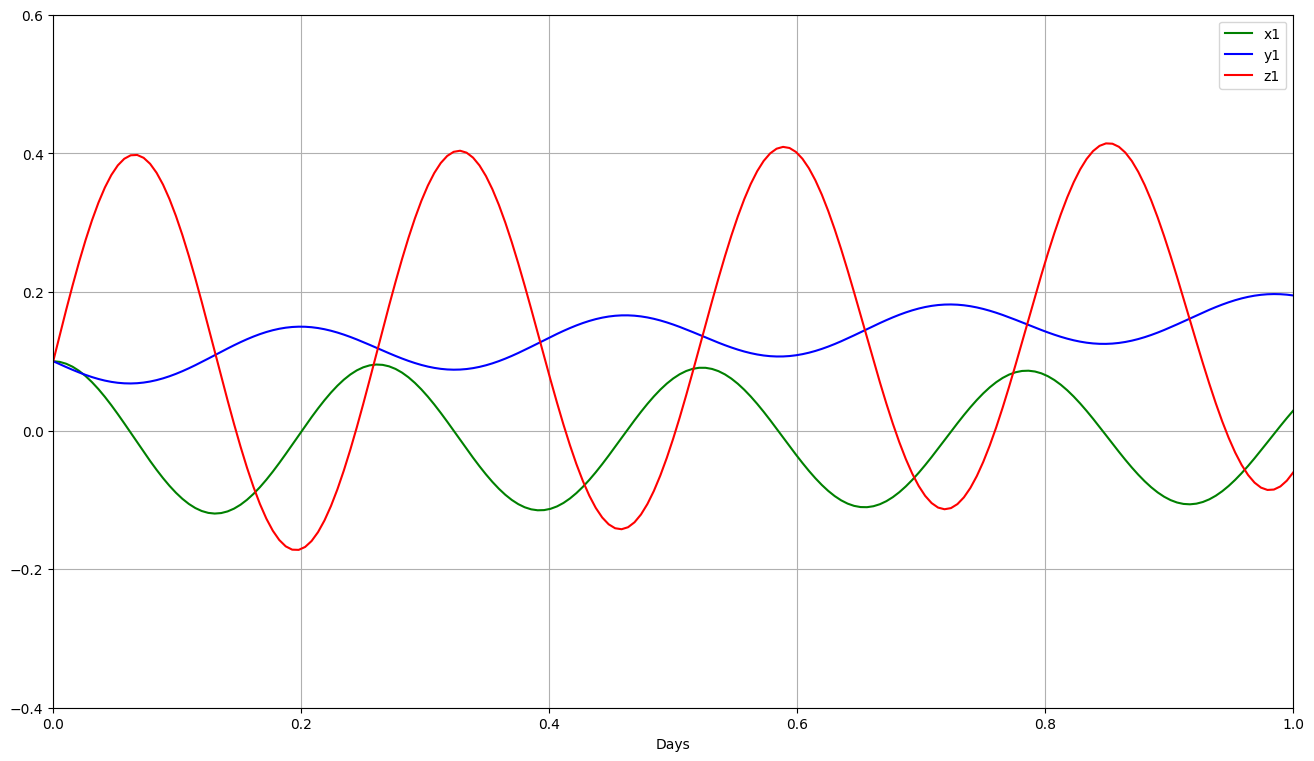

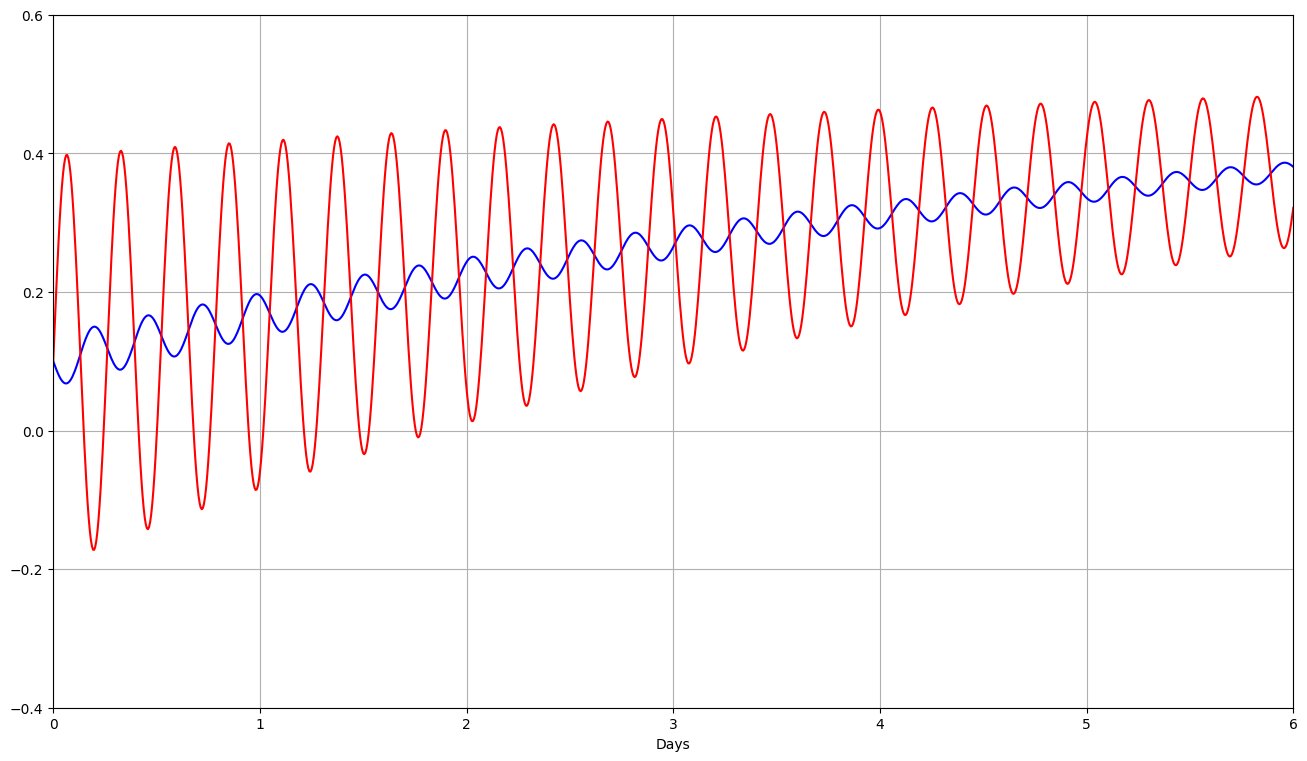

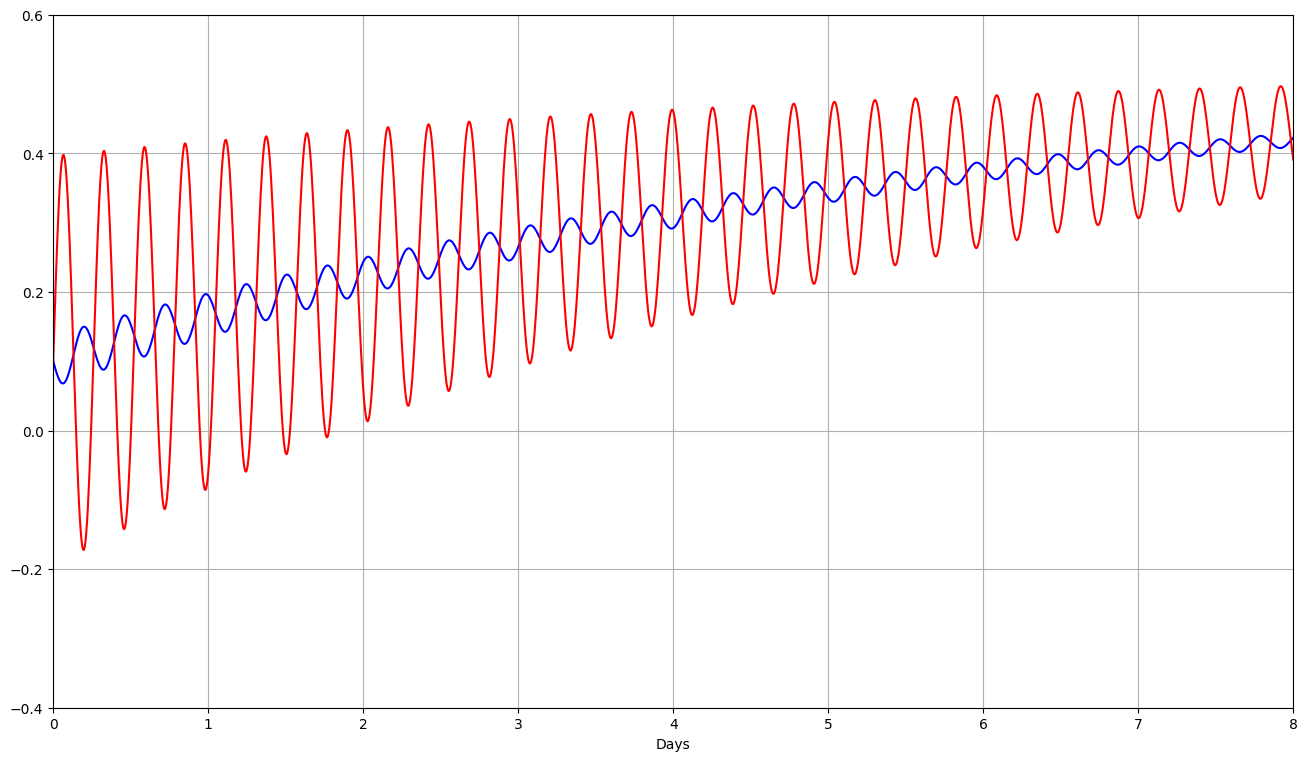

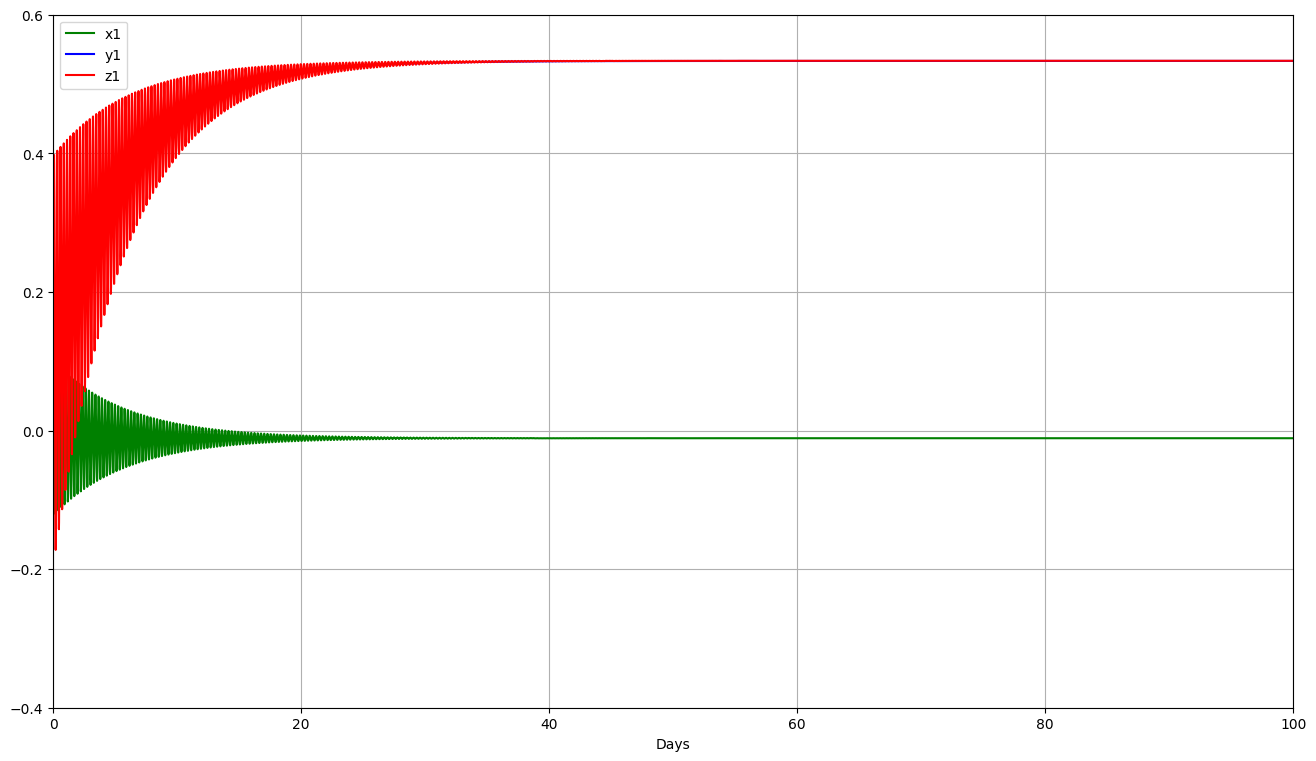

In [6]:
# SIMULATION STANDARD CONDITIONS - FIGURE 1

# Simulation days
total_days = 100

# Initial conditions
x0 = [0.1, 0, 0]
y0 = [0.1, 0, 0]
z0 = [0.1, 0, 0]

# PE model simulation
t_fig1, x_fig1, y_fig1, z_fig1 = solve_pe_ivp(x0, y0, z0, total_days)

# Plotting the results
evolution_x1y1z1(t_fig1, x_fig1, y_fig1, z_fig1, 1)
evolution_y1z1(t_fig1, y_fig1, z_fig1, 6)
evolution_y1z1(t_fig1, y_fig1, z_fig1, 8)
evolution_x1y1z1(t_fig1, x_fig1, y_fig1, z_fig1, total_days)
plt.show()

### Hadley conditions 01

According to [2], the Hadley conditions can be applied to the PE Model using the following values:

$x_1 = -v_0a_1y_1$

$y_1 = F_1/a_1v_0(1 + a_1g_0 + v_0^2a_1^2)$

$z_1 = (1 + v_0^2a_1^2)y_1$

$x_2 = x_3 = y_2 = y_3 = z_2 = z_3 = 0$

This simulation allows us to study the attractors generated by the PE model.

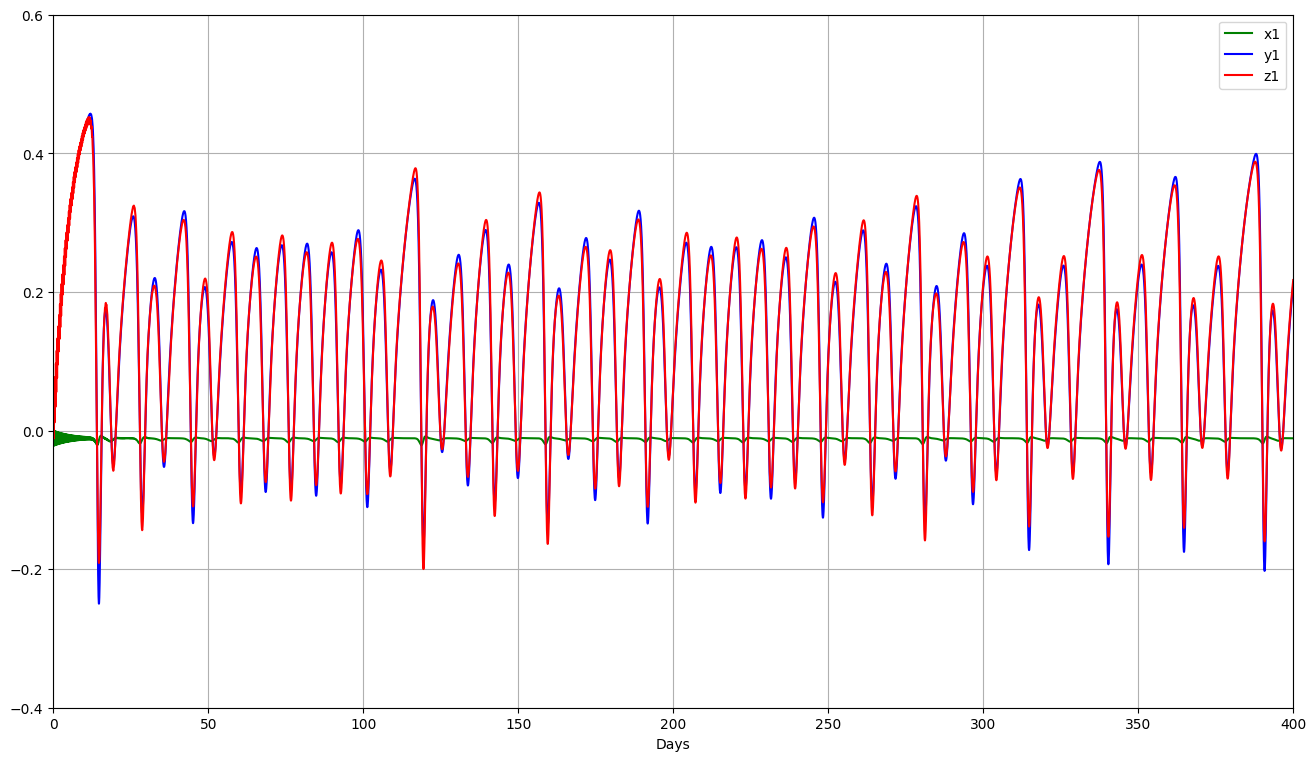

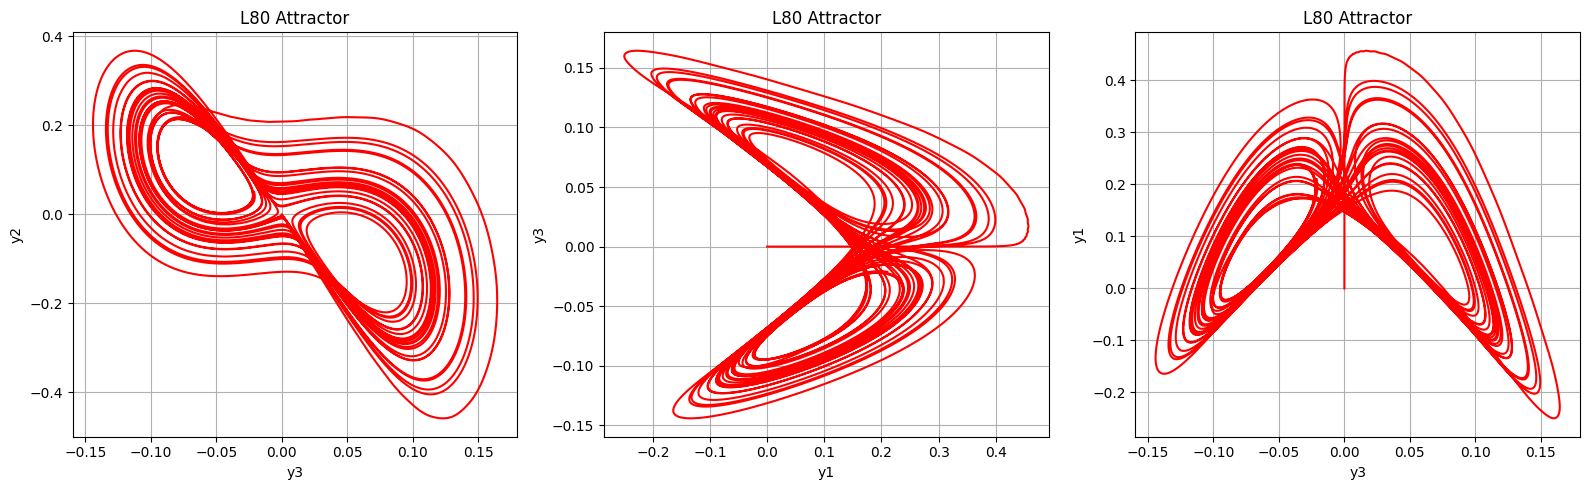

In [5]:
# SIMULATION HADLEY CONDITIONS 01

# Simulation days
hadley01_days = 400

# Initial conditions
y1 = (
    vector_f[1]
    / vector_a[1]
    * nu_0
    * (1 + vector_a[1] * g_0 + nu_0**2 * vector_a[1] ** 2)
)
z1 = (1 + nu_0**2 * vector_a[1] ** 2) * y1
x1 = -nu_0 * vector_a[1] * y1

hadley01_initial_x = [x1, 0, 0]
hadley01_initial_y = [y1, -(10 ** (-5)), 0]
hadley01_initial_z = [z1, 10 ** (-5), 0]

# PE model simulation
t_hadley01, x_hadley01, y_hadley01, z_hadley01 = solve_pe_ivp(
    hadley01_initial_x, hadley01_initial_y, hadley01_initial_z, hadley01_days
)

# Plot
evolution_x1y1z1(t_hadley01, x_hadley01, y_hadley01, z_hadley01, hadley01_days)
plot_bidimensional_y(y_hadley01)
plt.show()

## 📚 References

[1] Lorenz, E. N. (1980). Attractor sets and quasi-geostrophic equilibrium. Journal of the Atmospheric Sciences, 37(8), 1685–1699. https://doi.org/10.1175/1520-0469(1980)037<1685:asaqge>2.0.co;2

[2] Gent, P. R., & McWilliams, J. C. (1982). Intermediate model solutions to the Lorenz equations: Strange attractors and other phenomena. Journal of the Atmospheric Sciences, 39(1), 3–13. doi:10.1175/1520-0469(1982)039<0003:imsttl>2.0.co;2

[3] Chekroun, M. D., Liu, H., & McWilliams, J. C. (2017). The emergence of fast oscillations in a reduced primitive equation model and its implications for closure theories. Computers & Fluids, 151, 3–22. doi:10.1016/j.compfluid.2016.07.005

_Translated with [DeepL- Free version](https://www.deepl.com)_